In [1]:
trial_number_ml = "003"
random_state_init = 333

In [2]:
# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# optuna
import optuna
import optuna.integration.lightgbm as lgb_optuna
from optuna.pruners import MedianPruner
from optuna.integration import OptunaSearchCV

#xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance


# metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, make_scorer, precision_recall_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold

#lightgbm
import lightgbm as lgb
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns


from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole # Enables RDKit's IPython integration for Jupyter notebooks.
from IPython.display import display


import os
from rdkit.Chem.Draw import rdMolDraw2D

import joblib


# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import os

# Get the current working directory
current_dir = os.getcwd()
print("Current Directory:", current_dir)

# Verify the change
new_dir = os.getcwd()
print("New Working Directory:", new_dir)


Current Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model2_rna_prot_bin
New Working Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model2_rna_prot_bin


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def load_and_concatenate_datasets(file_paths):
    """
    Load datasets from given file paths and concatenate them into a single DataFrame.
    """
    dataframes = [pd.read_pickle(path) for path in file_paths]
    return pd.concat(dataframes, ignore_index=True)

def preprocess_data(df, feature_col='ecfp6', label_col='label'):
    """
    Preprocess the DataFrame by extracting features and labels.
    """
    X = np.array([list(map(int, list(fp))) for fp in df[feature_col]])
    y = df[label_col].values
    return X, y

def stratified_train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Split the dataset into training and test sets, ensuring stratification of the target variable.
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Paths for the datasets
model2_files = ['../../data_for_ml/ml_datasets_set2/model2_rna_bin_protein_bin/data.pkl']

# Load datasets
model2_df = load_and_concatenate_datasets(model2_files)

# Preprocess datasets
X2, y2 = preprocess_data(model2_df)

# Split datasets
X_train, X_test, y_train, y_test = stratified_train_test_split(X2, y2)

# Output shapes
print(f"Model 2 - Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


Model 2 - Training set size: 3137, Test set size: 785


In [5]:
import numpy as np
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from optuna.integration import OptunaSearchCV


def model_training_and_evaluation(model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a model using given datasets.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return model, accuracy

def objective(trial, model_cls, X_train, y_train):
    """
    Objective function for hyperparameter tuning with Optuna.
    
    Args:
    - trial (optuna.trial.Trial): An individual trial object.
    - model_cls: The classifier class to be optimized.
    - X_train, y_train: Training data.
    
    Returns:
    - The accuracy of the model on the cross-validation folds.
    """
    # Suggest hyperparameters specific to the RandomForestClassifier
    if model_cls == RandomForestClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 10, 100)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        
        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                          min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                          max_features=max_features, random_state=random_state_init, n_jobs=4)
        
    elif model_cls == XGBClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        subsample = trial.suggest_float('subsample', 0.5, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
        gamma = trial.suggest_float('gamma', 0, 5)
        reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10.0, log=True)
        reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10.0, log=True)

        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                        learning_rate=learning_rate, min_child_weight=min_child_weight,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        gamma=gamma, reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                        random_state=random_state_init, use_label_encoder=False, eval_metric='logloss', n_jobs=4)
    
    elif model_cls == LGBMClassifier:
        boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
        num_leaves = trial.suggest_int('num_leaves', 31, 100)
        max_depth = trial.suggest_int('max_depth', -1, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        min_child_weight = trial.suggest_float('min_child_weight', 1e-3, 1e-1, log=True)
        min_child_samples = trial.suggest_int('min_child_samples', 20, 2000)
        subsample = trial.suggest_float('subsample', 0.8, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.8, 1.0)
        reg_alpha = trial.suggest_float('reg_alpha', 1e-10, 1.0, log=True)
        reg_lambda = trial.suggest_float('reg_lambda', 1e-10, 1.0, log=True)
        
        model = model_cls(boosting_type=boosting_type, num_leaves=num_leaves, max_depth=max_depth,
                        learning_rate=learning_rate, n_estimators=n_estimators,
                        min_child_weight=min_child_weight, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=random_state_init, verbosity=-1, n_jobs=4)
    else:
        raise NotImplementedError("Optuna objective function needs to be extended for other classifiers.")
    
    # Cross-validation within the Optuna trial
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state_init)
    accuracies = []
    for train_index, val_index in stratified_kfold.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict(X_fold_val)
        accuracy = accuracy_score(y_fold_val, y_fold_pred)
        accuracies.append(accuracy)
        
        trial.report(np.mean(accuracies), len(accuracies))
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return np.mean(accuracies)

def perform_hyperparameter_tuning(model_cls, X_train, y_train, n_trials=50):
    """
    Perform hyperparameter tuning for the given model class using Optuna.
    """
    study = optuna.create_study(direction='maximize')
    objective_with_model = lambda trial: objective(trial, model_cls, X_train, y_train)
    study.optimize(objective_with_model, n_trials=n_trials, n_jobs=4) 
    
    print(f"Best trial for {model_cls.__name__}:")
    print(f"  Value: {study.best_trial.value}")
    print("  Params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
    print('')
    return study.best_params

print('')
# Example usage for RandomForestClassifier
best_params_rf = perform_hyperparameter_tuning(RandomForestClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for RandomForestClassifier:", best_params_rf)
# Train and evaluate the final model with the best hyperparameters
best_rf = RandomForestClassifier(**best_params_rf, random_state=random_state_init)
final_model, final_accuracy = model_training_and_evaluation(best_rf, X_train, y_train, X_test, y_test)
print(f"RandomForestClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for XGBClassifier
best_params_xgb = perform_hyperparameter_tuning(XGBClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for XGBClassifier:", best_params_xgb)
# Train and evaluate the final model with the best hyperparameters
best_xgb = XGBClassifier(**best_params_xgb, random_state=random_state_init, use_label_encoder=False, eval_metric='logloss')
final_model, final_accuracy = model_training_and_evaluation(best_xgb, X_train, y_train, X_test, y_test)
print(f"XGBClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for LGBMClassifier
best_params_lgb = perform_hyperparameter_tuning(LGBMClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for LGBMClassifier:", best_params_lgb)
# Train and evaluate the final model with the best hyperparameters
best_lgb = LGBMClassifier(**best_params_lgb, random_state=random_state_init, verbosity=-1)
final_model, final_accuracy = model_training_and_evaluation(best_lgb, X_train, y_train, X_test, y_test)
print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")

print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")
print('')


[I 2024-05-01 15:42:02,411] A new study created in memory with name: no-name-dc339807-6a58-41dd-88a7-cefa28b2fd27


[I 2024-05-01 15:42:54,347] Trial 1 finished with value: 0.8552728085413304 and parameters: {'n_estimators': 444, 'max_depth': 23, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 0.8552728085413304.


[I 2024-05-01 15:42:54,838] Trial 2 finished with value: 0.8610113877629801 and parameters: {'n_estimators': 369, 'max_depth': 44, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8610113877629801.


[I 2024-05-01 15:43:01,448] Trial 3 finished with value: 0.8390180721055678 and parameters: {'n_estimators': 456, 'max_depth': 90, 'min_samples_split': 12, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8610113877629801.


[I 2024-05-01 15:43:29,462] Trial 4 finished with value: 0.8645155883338921 and parameters: {'n_estimators': 256, 'max_depth': 90, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.8645155883338921.


[I 2024-05-01 15:43:33,688] Trial 5 finished with value: 0.8418843141437844 and parameters: {'n_estimators': 362, 'max_depth': 98, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 4 with value: 0.8645155883338921.


[I 2024-05-01 15:43:38,371] Trial 8 pruned. 


[I 2024-05-01 15:43:43,629] Trial 6 pruned. 


[I 2024-05-01 15:43:45,793] Trial 9 pruned. 


[I 2024-05-01 15:43:48,196] Trial 7 pruned. 


[I 2024-05-01 15:43:58,261] Trial 0 finished with value: 0.852723006125621 and parameters: {'n_estimators': 890, 'max_depth': 40, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.8645155883338921.


[I 2024-05-01 15:44:01,123] Trial 10 pruned. 


[I 2024-05-01 15:44:03,569] Trial 11 pruned. 


[I 2024-05-01 15:44:04,148] Trial 12 pruned. 


[I 2024-05-01 15:44:13,538] Trial 13 pruned. 


[I 2024-05-01 15:44:19,802] Trial 14 finished with value: 0.868019788904804 and parameters: {'n_estimators': 119, 'max_depth': 78, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.868019788904804.


[I 2024-05-01 15:44:21,732] Trial 16 finished with value: 0.8718495718160486 and parameters: {'n_estimators': 104, 'max_depth': 77, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 16 with value: 0.8718495718160486.


[I 2024-05-01 15:44:26,140] Trial 15 finished with value: 0.8693012931866434 and parameters: {'n_estimators': 133, 'max_depth': 79, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 16 with value: 0.8718495718160486.


[I 2024-05-01 15:44:31,546] Trial 20 pruned. 


[I 2024-05-01 15:44:39,435] Trial 17 finished with value: 0.8708946657320779 and parameters: {'n_estimators': 110, 'max_depth': 74, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 16 with value: 0.8718495718160486.


[I 2024-05-01 15:44:51,112] Trial 18 finished with value: 0.8715295766921647 and parameters: {'n_estimators': 122, 'max_depth': 80, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 16 with value: 0.8718495718160486.


[I 2024-05-01 15:45:01,950] Trial 19 finished with value: 0.8724885462062801 and parameters: {'n_estimators': 156, 'max_depth': 74, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 19 with value: 0.8724885462062801.


[I 2024-05-01 15:45:03,408] Trial 23 pruned. 


[I 2024-05-01 15:45:15,344] Trial 25 pruned. 


[I 2024-05-01 15:45:25,151] Trial 24 pruned. 


[I 2024-05-01 15:45:31,887] Trial 21 finished with value: 0.871532116336005 and parameters: {'n_estimators': 239, 'max_depth': 66, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 19 with value: 0.8724885462062801.


[I 2024-05-01 15:45:39,355] Trial 22 finished with value: 0.8705756864657299 and parameters: {'n_estimators': 244, 'max_depth': 71, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 19 with value: 0.8724885462062801.


[I 2024-05-01 15:46:03,610] Trial 26 finished with value: 0.8728054937575553 and parameters: {'n_estimators': 196, 'max_depth': 66, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8728054937575553.


[I 2024-05-01 15:46:10,273] Trial 27 finished with value: 0.8718470321722082 and parameters: {'n_estimators': 178, 'max_depth': 100, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8728054937575553.


[I 2024-05-01 15:46:19,704] Trial 30 pruned. 


[I 2024-05-01 15:46:35,883] Trial 31 pruned. 


[I 2024-05-01 15:46:40,604] Trial 32 pruned. 


[I 2024-05-01 15:46:49,418] Trial 28 finished with value: 0.8702561992706143 and parameters: {'n_estimators': 318, 'max_depth': 69, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8728054937575553.


[I 2024-05-01 15:46:49,481] Trial 33 pruned. 


[I 2024-05-01 15:46:58,579] Trial 36 pruned. 


[I 2024-05-01 15:46:59,593] Trial 29 finished with value: 0.8728054937575553 and parameters: {'n_estimators': 319, 'max_depth': 100, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8728054937575553.


[I 2024-05-01 15:47:27,379] Trial 34 finished with value: 0.8721665193673239 and parameters: {'n_estimators': 176, 'max_depth': 98, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8728054937575553.


[I 2024-05-01 15:47:35,352] Trial 35 finished with value: 0.8721660114385559 and parameters: {'n_estimators': 173, 'max_depth': 86, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8728054937575553.


[I 2024-05-01 15:47:42,850] Trial 39 pruned. 


[I 2024-05-01 15:47:47,977] Trial 37 finished with value: 0.8699341724316583 and parameters: {'n_estimators': 186, 'max_depth': 86, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8728054937575553.


[I 2024-05-01 15:47:51,172] Trial 40 pruned. 


[I 2024-05-01 15:47:53,369] Trial 41 pruned. 


[I 2024-05-01 15:48:01,686] Trial 42 pruned. 


[I 2024-05-01 15:48:02,436] Trial 44 pruned. 


[I 2024-05-01 15:48:03,700] Trial 43 pruned. 


[I 2024-05-01 15:48:13,361] Trial 46 pruned. 


[I 2024-05-01 15:48:46,614] Trial 45 finished with value: 0.8769461290748584 and parameters: {'n_estimators': 163, 'max_depth': 86, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 45 with value: 0.8769461290748584.


[I 2024-05-01 15:48:47,125] Trial 38 finished with value: 0.8680213126911083 and parameters: {'n_estimators': 419, 'max_depth': 85, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 45 with value: 0.8769461290748584.


[I 2024-05-01 15:48:47,798] Trial 47 finished with value: 0.8747183534981054 and parameters: {'n_estimators': 156, 'max_depth': 88, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 45 with value: 0.8769461290748584.


[I 2024-05-01 15:49:08,970] Trial 48 finished with value: 0.872802954113715 and parameters: {'n_estimators': 359, 'max_depth': 82, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 45 with value: 0.8769461290748584.


[I 2024-05-01 15:49:21,705] Trial 49 finished with value: 0.8724860065624396 and parameters: {'n_estimators': 591, 'max_depth': 82, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 45 with value: 0.8769461290748584.


Best trial for RandomForestClassifier:
  Value: 0.8769461290748584
  Params: 
    n_estimators: 163
    max_depth: 86
    min_samples_split: 2
    min_samples_leaf: 1
    max_features: sqrt

Best hyperparameters for RandomForestClassifier: {'n_estimators': 163, 'max_depth': 86, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


[I 2024-05-01 15:49:25,253] A new study created in memory with name: no-name-013ea07a-4613-4bc9-834a-8017a30f9a70


RandomForestClassifier accuracy: 0.8701



[I 2024-05-01 15:49:41,451] Trial 1 finished with value: 0.8485788153069412 and parameters: {'n_estimators': 376, 'max_depth': 9, 'learning_rate': 0.14838798305216397, 'min_child_weight': 9, 'subsample': 0.6590603524809784, 'colsample_bytree': 0.5438124998604497, 'gamma': 4.01473984115916, 'reg_lambda': 0.25878318967992403, 'reg_alpha': 0.34763003694633127}. Best is trial 1 with value: 0.8485788153069412.


[I 2024-05-01 15:49:53,349] Trial 0 finished with value: 0.8527184347667085 and parameters: {'n_estimators': 792, 'max_depth': 3, 'learning_rate': 0.2981602663241483, 'min_child_weight': 6, 'subsample': 0.9961425440990411, 'colsample_bytree': 0.9861382482794411, 'gamma': 2.328861861519449, 'reg_lambda': 0.20724840274525602, 'reg_alpha': 0.04964383809089794}. Best is trial 0 with value: 0.8527184347667085.


[I 2024-05-01 15:49:56,609] Trial 3 finished with value: 0.8651545627241235 and parameters: {'n_estimators': 762, 'max_depth': 3, 'learning_rate': 0.14167805825558438, 'min_child_weight': 3, 'subsample': 0.629968161603478, 'colsample_bytree': 0.5071968939778972, 'gamma': 1.457574309778416, 'reg_lambda': 2.674373751913632, 'reg_alpha': 0.42380808623185906}. Best is trial 3 with value: 0.8651545627241235.


[I 2024-05-01 15:50:05,291] Trial 2 finished with value: 0.8638776298011968 and parameters: {'n_estimators': 888, 'max_depth': 7, 'learning_rate': 0.04105042308580673, 'min_child_weight': 2, 'subsample': 0.6332211829873202, 'colsample_bytree': 0.5287350551114903, 'gamma': 3.7979751850129695, 'reg_lambda': 0.19866001193096558, 'reg_alpha': 0.4350521504958591}. Best is trial 3 with value: 0.8651545627241235.


[I 2024-05-01 15:50:06,481] Trial 4 finished with value: 0.8635596663923852 and parameters: {'n_estimators': 352, 'max_depth': 9, 'learning_rate': 0.10638036297877458, 'min_child_weight': 8, 'subsample': 0.6070348798657257, 'colsample_bytree': 0.794680241272819, 'gamma': 1.4730733266940437, 'reg_lambda': 0.023475349073191883, 'reg_alpha': 0.13576577961477457}. Best is trial 3 with value: 0.8651545627241235.


[I 2024-05-01 15:50:07,123] Trial 7 pruned. 


[I 2024-05-01 15:50:08,311] Trial 8 pruned. 


[I 2024-05-01 15:50:09,928] Trial 10 pruned. 


[I 2024-05-01 15:50:10,280] Trial 9 pruned. 


[I 2024-05-01 15:50:12,518] Trial 6 finished with value: 0.8648371072440801 and parameters: {'n_estimators': 316, 'max_depth': 7, 'learning_rate': 0.20979738880766793, 'min_child_weight': 2, 'subsample': 0.6996429993799661, 'colsample_bytree': 0.8342197275534571, 'gamma': 2.094166091679069, 'reg_lambda': 0.035503238225784335, 'reg_alpha': 0.03754732489893118}. Best is trial 3 with value: 0.8651545627241235.


[I 2024-05-01 15:50:16,697] Trial 5 finished with value: 0.8702582309856866 and parameters: {'n_estimators': 536, 'max_depth': 7, 'learning_rate': 0.28144576225346235, 'min_child_weight': 4, 'subsample': 0.8540375584504246, 'colsample_bytree': 0.5185444236729082, 'gamma': 1.5287010016131002, 'reg_lambda': 6.263459951140089, 'reg_alpha': 0.939464742717006}. Best is trial 5 with value: 0.8702582309856866.


[I 2024-05-01 15:50:16,924] Trial 11 pruned. 


[I 2024-05-01 15:50:18,253] Trial 12 pruned. 


[I 2024-05-01 15:50:47,405] Trial 13 finished with value: 0.861645790794299 and parameters: {'n_estimators': 574, 'max_depth': 4, 'learning_rate': 0.06675265114593652, 'min_child_weight': 4, 'subsample': 0.5185596852455782, 'colsample_bytree': 0.643030534964032, 'gamma': 0.07857545871777227, 'reg_lambda': 8.700477759579464, 'reg_alpha': 2.730542794642267}. Best is trial 5 with value: 0.8702582309856866.


[I 2024-05-01 15:50:50,084] Trial 14 finished with value: 0.8743978504454535 and parameters: {'n_estimators': 579, 'max_depth': 5, 'learning_rate': 0.11253075497947149, 'min_child_weight': 4, 'subsample': 0.8365540650185137, 'colsample_bytree': 0.6661527494510818, 'gamma': 0.18503487387694406, 'reg_lambda': 9.747616258356869, 'reg_alpha': 2.0277757294834897}. Best is trial 14 with value: 0.8743978504454535.


[I 2024-05-01 15:50:51,760] Trial 16 finished with value: 0.8708900943731651 and parameters: {'n_estimators': 557, 'max_depth': 5, 'learning_rate': 0.15768046304559458, 'min_child_weight': 4, 'subsample': 0.8297753809577086, 'colsample_bytree': 0.503310343294079, 'gamma': 0.19618570509716426, 'reg_lambda': 9.411520305802451, 'reg_alpha': 2.0235171892036297}. Best is trial 14 with value: 0.8743978504454535.


[I 2024-05-01 15:50:52,263] Trial 15 finished with value: 0.8721675352248601 and parameters: {'n_estimators': 584, 'max_depth': 5, 'learning_rate': 0.11990242224975264, 'min_child_weight': 4, 'subsample': 0.8396040077702308, 'colsample_bytree': 0.6165630440668993, 'gamma': 0.4073735813783377, 'reg_lambda': 8.20421962356805, 'reg_alpha': 2.0507946823601646}. Best is trial 14 with value: 0.8743978504454535.


[I 2024-05-01 15:50:54,112] Trial 18 pruned. 


[I 2024-05-01 15:50:54,215] Trial 19 pruned. 


[I 2024-05-01 15:50:55,939] Trial 20 pruned. 


[I 2024-05-01 15:50:58,136] Trial 21 pruned. 


[I 2024-05-01 15:50:59,793] Trial 23 pruned. 


[I 2024-05-01 15:51:01,786] Trial 22 pruned. 


[I 2024-05-01 15:51:07,780] Trial 26 pruned. 


[I 2024-05-01 15:51:14,419] Trial 17 finished with value: 0.8661089608793262 and parameters: {'n_estimators': 617, 'max_depth': 5, 'learning_rate': 0.16188252421102114, 'min_child_weight': 5, 'subsample': 0.8404353422440012, 'colsample_bytree': 0.5153278362116623, 'gamma': 0.8584811104684053, 'reg_lambda': 1.8070237564827214, 'reg_alpha': 1.3129297756368752}. Best is trial 14 with value: 0.8743978504454535.


[I 2024-05-01 15:51:23,070] Trial 24 finished with value: 0.8594134438586332 and parameters: {'n_estimators': 665, 'max_depth': 4, 'learning_rate': 0.13871856256129364, 'min_child_weight': 3, 'subsample': 0.9108522357500981, 'colsample_bytree': 0.5882332672707993, 'gamma': 0.8981561849849555, 'reg_lambda': 3.5214106496596647, 'reg_alpha': 2.579018519970618}. Best is trial 14 with value: 0.8743978504454535.


[I 2024-05-01 15:51:27,997] Trial 25 finished with value: 0.8606883450664877 and parameters: {'n_estimators': 656, 'max_depth': 4, 'learning_rate': 0.13287747922505944, 'min_child_weight': 3, 'subsample': 0.9037593639479716, 'colsample_bytree': 0.5794308221368266, 'gamma': 0.9780345293918833, 'reg_lambda': 3.6804466352723013, 'reg_alpha': 2.7982565411652582}. Best is trial 14 with value: 0.8743978504454535.


[I 2024-05-01 15:51:33,921] Trial 27 finished with value: 0.8673843700159489 and parameters: {'n_estimators': 422, 'max_depth': 4, 'learning_rate': 0.08204754583122037, 'min_child_weight': 4, 'subsample': 0.8859232186143242, 'colsample_bytree': 0.7724360268012247, 'gamma': 0.5426202967194881, 'reg_lambda': 5.726821836847786, 'reg_alpha': 2.0661196485824633}. Best is trial 14 with value: 0.8743978504454535.


[I 2024-05-01 15:51:36,754] Trial 31 pruned. 


[I 2024-05-01 15:51:38,125] Trial 28 finished with value: 0.8616478225093713 and parameters: {'n_estimators': 439, 'max_depth': 4, 'learning_rate': 0.08444752296996737, 'min_child_weight': 4, 'subsample': 0.8943059457283459, 'colsample_bytree': 0.7450424207040521, 'gamma': 0.36917667690683914, 'reg_lambda': 6.19640374561898, 'reg_alpha': 4.517689902971674}. Best is trial 14 with value: 0.8743978504454535.


[I 2024-05-01 15:51:43,585] Trial 33 pruned. 


[I 2024-05-01 15:51:49,354] Trial 32 pruned. 


[I 2024-05-01 15:51:53,859] Trial 29 finished with value: 0.8721680431536282 and parameters: {'n_estimators': 423, 'max_depth': 6, 'learning_rate': 0.08402763219217937, 'min_child_weight': 4, 'subsample': 0.8846306089962193, 'colsample_bytree': 0.7525858008485844, 'gamma': 0.3642016090499662, 'reg_lambda': 6.886541647293272, 'reg_alpha': 0.012222350581279897}. Best is trial 14 with value: 0.8743978504454535.


[I 2024-05-01 15:52:02,588] Trial 34 finished with value: 0.862280701754386 and parameters: {'n_estimators': 524, 'max_depth': 6, 'learning_rate': 0.2993147981555141, 'min_child_weight': 5, 'subsample': 0.8671007400857749, 'colsample_bytree': 0.6304668127185195, 'gamma': 1.3135024544065592, 'reg_lambda': 6.05203509192017, 'reg_alpha': 0.8280881888968668}. Best is trial 14 with value: 0.8743978504454535.


[I 2024-05-01 15:52:09,978] Trial 36 finished with value: 0.8702592468432228 and parameters: {'n_estimators': 286, 'max_depth': 5, 'learning_rate': 0.1198125886554948, 'min_child_weight': 5, 'subsample': 0.9622778457133148, 'colsample_bytree': 0.6700746402968254, 'gamma': 1.1989506286203242, 'reg_lambda': 9.751308301200945, 'reg_alpha': 0.01098920600746128}. Best is trial 14 with value: 0.8743978504454535.


[I 2024-05-01 15:52:11,312] Trial 30 finished with value: 0.8763086784709312 and parameters: {'n_estimators': 444, 'max_depth': 10, 'learning_rate': 0.09836902960407119, 'min_child_weight': 4, 'subsample': 0.7693480824532811, 'colsample_bytree': 0.7500406521544764, 'gamma': 0.37882302517923394, 'reg_lambda': 5.925753093909384, 'reg_alpha': 0.012731682305766972}. Best is trial 30 with value: 0.8763086784709312.


[I 2024-05-01 15:52:14,263] Trial 35 finished with value: 0.8718465242434401 and parameters: {'n_estimators': 528, 'max_depth': 8, 'learning_rate': 0.11579589459800387, 'min_child_weight': 5, 'subsample': 0.8599878768240077, 'colsample_bytree': 0.5041890116741279, 'gamma': 1.2926581784110402, 'reg_lambda': 6.174337261525541, 'reg_alpha': 0.8560338426260983}. Best is trial 30 with value: 0.8763086784709312.


[I 2024-05-01 15:52:15,756] Trial 38 pruned. 


[I 2024-05-01 15:52:28,235] Trial 41 finished with value: 0.8740778553215698 and parameters: {'n_estimators': 412, 'max_depth': 10, 'learning_rate': 0.09746287144179785, 'min_child_weight': 2, 'subsample': 0.7646804625636164, 'colsample_bytree': 0.7992799429465041, 'gamma': 1.7465968289357816, 'reg_lambda': 2.2661474644650927, 'reg_alpha': 0.02056892334715252}. Best is trial 30 with value: 0.8763086784709312.


[I 2024-05-01 15:52:29,895] Trial 42 pruned. 


[I 2024-05-01 15:52:31,200] Trial 37 finished with value: 0.87440140594683 and parameters: {'n_estimators': 860, 'max_depth': 5, 'learning_rate': 0.04966299832187549, 'min_child_weight': 4, 'subsample': 0.9603742270645654, 'colsample_bytree': 0.6794533854634108, 'gamma': 0.05389874947059303, 'reg_lambda': 2.513592125082836, 'reg_alpha': 1.8655432726333814}. Best is trial 30 with value: 0.8763086784709312.


[I 2024-05-01 15:52:32,784] Trial 40 finished with value: 0.8794954235617997 and parameters: {'n_estimators': 389, 'max_depth': 10, 'learning_rate': 0.05022773291744822, 'min_child_weight': 2, 'subsample': 0.7740944899322606, 'colsample_bytree': 0.8041561466485334, 'gamma': 0.506125235600277, 'reg_lambda': 2.210916805503217, 'reg_alpha': 0.02378431698814122}. Best is trial 40 with value: 0.8794954235617997.


[I 2024-05-01 15:52:33,082] Trial 39 finished with value: 0.8791784760105242 and parameters: {'n_estimators': 477, 'max_depth': 10, 'learning_rate': 0.05702451908060382, 'min_child_weight': 2, 'subsample': 0.7655655356401897, 'colsample_bytree': 0.9899382303983055, 'gamma': 0.4719593767079256, 'reg_lambda': 2.2737719541083603, 'reg_alpha': 0.019948338204526475}. Best is trial 40 with value: 0.8794954235617997.


[I 2024-05-01 15:52:36,476] Trial 45 pruned. 


[I 2024-05-01 15:52:41,617] Trial 43 finished with value: 0.8715300846209327 and parameters: {'n_estimators': 322, 'max_depth': 9, 'learning_rate': 0.06003377182918513, 'min_child_weight': 2, 'subsample': 0.7048117514313004, 'colsample_bytree': 0.8648045390940463, 'gamma': 1.592792123426259, 'reg_lambda': 0.7991868644191127, 'reg_alpha': 0.05730646898704328}. Best is trial 40 with value: 0.8794954235617997.


[I 2024-05-01 15:52:42,790] Trial 44 finished with value: 0.8750337772630766 and parameters: {'n_estimators': 320, 'max_depth': 9, 'learning_rate': 0.05469845571383124, 'min_child_weight': 2, 'subsample': 0.766361737234201, 'colsample_bytree': 0.7768531909071313, 'gamma': 1.6452064310407781, 'reg_lambda': 1.0023394975305373, 'reg_alpha': 0.018590605119615113}. Best is trial 40 with value: 0.8794954235617997.


[I 2024-05-01 15:52:45,228] Trial 49 pruned. 


[I 2024-05-01 15:52:50,709] Trial 46 finished with value: 0.8798169424719878 and parameters: {'n_estimators': 317, 'max_depth': 9, 'learning_rate': 0.03311571444818741, 'min_child_weight': 3, 'subsample': 0.7121906395189115, 'colsample_bytree': 0.9588515757540952, 'gamma': 0.0361182341462334, 'reg_lambda': 0.9603467899363962, 'reg_alpha': 0.05600684535785588}. Best is trial 46 with value: 0.8798169424719878.


[I 2024-05-01 15:53:24,824] Trial 48 finished with value: 0.8810923516086104 and parameters: {'n_estimators': 772, 'max_depth': 10, 'learning_rate': 0.04568770189283991, 'min_child_weight': 3, 'subsample': 0.6712298978380145, 'colsample_bytree': 0.9571364700830632, 'gamma': 0.022161237790941368, 'reg_lambda': 4.505578730768604, 'reg_alpha': 0.03533006204111744}. Best is trial 48 with value: 0.8810923516086104.


[I 2024-05-01 15:53:27,459] Trial 47 finished with value: 0.8785405174778289 and parameters: {'n_estimators': 797, 'max_depth': 9, 'learning_rate': 0.05680239095858279, 'min_child_weight': 3, 'subsample': 0.6841209823186666, 'colsample_bytree': 0.9729146732746502, 'gamma': 0.01646918527716762, 'reg_lambda': 4.406368511575604, 'reg_alpha': 0.04161896423057927}. Best is trial 48 with value: 0.8810923516086104.


Best trial for XGBClassifier:
  Value: 0.8810923516086104
  Params: 
    n_estimators: 772
    max_depth: 10
    learning_rate: 0.04568770189283991
    min_child_weight: 3
    subsample: 0.6712298978380145
    colsample_bytree: 0.9571364700830632
    gamma: 0.022161237790941368
    reg_lambda: 4.505578730768604
    reg_alpha: 0.03533006204111744

Best hyperparameters for XGBClassifier: {'n_estimators': 772, 'max_depth': 10, 'learning_rate': 0.04568770189283991, 'min_child_weight': 3, 'subsample': 0.6712298978380145, 'colsample_bytree': 0.9571364700830632, 'gamma': 0.022161237790941368, 'reg_lambda': 4.505578730768604, 'reg_alpha': 0.03533006204111744}


[I 2024-05-01 15:59:21,958] A new study created in memory with name: no-name-bbc9af9b-d79b-4313-8def-84d3e32db7f0


XGBClassifier accuracy: 0.8675



[I 2024-05-01 15:59:22,732] Trial 2 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 65, 'max_depth': 1, 'learning_rate': 0.22043743561237367, 'n_estimators': 441, 'min_child_weight': 0.0025688775625149806, 'min_child_samples': 1899, 'subsample': 0.8259925422729919, 'colsample_bytree': 0.8719755267365976, 'reg_alpha': 6.2822139760727055e-06, 'reg_lambda': 1.2931011462541889e-08}. Best is trial 2 with value: 0.4995215311004785.


[I 2024-05-01 15:59:22,931] Trial 1 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 85, 'max_depth': 15, 'learning_rate': 0.30251996006498116, 'n_estimators': 737, 'min_child_weight': 0.07074407112268016, 'min_child_samples': 1497, 'subsample': 0.9720736130499523, 'colsample_bytree': 0.9631636789646134, 'reg_alpha': 2.1081645993125253e-07, 'reg_lambda': 0.060617450260887856}. Best is trial 2 with value: 0.4995215311004785.


[I 2024-05-01 15:59:24,374] Trial 3 finished with value: 0.772707971434086 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': 15, 'learning_rate': 0.05073385997900849, 'n_estimators': 262, 'min_child_weight': 0.00134052615824933, 'min_child_samples': 457, 'subsample': 0.8980035318346695, 'colsample_bytree': 0.8107603908612747, 'reg_alpha': 0.00038300091829411733, 'reg_lambda': 0.23204931958273814}. Best is trial 3 with value: 0.772707971434086.


[I 2024-05-01 15:59:25,633] Trial 5 finished with value: 0.6863179227745101 and parameters: {'boosting_type': 'dart', 'num_leaves': 91, 'max_depth': 0, 'learning_rate': 0.25334399932624735, 'n_estimators': 182, 'min_child_weight': 0.08223652002643136, 'min_child_samples': 787, 'subsample': 0.8468412116935716, 'colsample_bytree': 0.9490393751060517, 'reg_alpha': 4.6601438336986815e-07, 'reg_lambda': 4.515677948707131e-10}. Best is trial 3 with value: 0.772707971434086.


[I 2024-05-01 15:59:26,173] Trial 6 finished with value: 0.8096867095358545 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 79, 'max_depth': 3, 'learning_rate': 0.46412388841810914, 'n_estimators': 170, 'min_child_weight': 0.029899078968106733, 'min_child_samples': 399, 'subsample': 0.98981526401528, 'colsample_bytree': 0.825618072517671, 'reg_alpha': 0.08271633141985035, 'reg_lambda': 2.678127321706465e-08}. Best is trial 6 with value: 0.8096867095358545.


[I 2024-05-01 15:59:26,218] Trial 7 pruned. 


[I 2024-05-01 15:59:26,416] Trial 9 pruned. 


[I 2024-05-01 15:59:26,918] Trial 0 finished with value: 0.8237070673208787 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 97, 'max_depth': 7, 'learning_rate': 0.43415460320960286, 'n_estimators': 442, 'min_child_weight': 0.0015268666918275364, 'min_child_samples': 308, 'subsample': 0.9572959031614254, 'colsample_bytree': 0.9976347978293558, 'reg_alpha': 5.6909083893124286e-05, 'reg_lambda': 5.292337689943657e-05}. Best is trial 0 with value: 0.8237070673208787.


[I 2024-05-01 15:59:27,043] Trial 11 pruned. 


[I 2024-05-01 15:59:28,322] Trial 10 finished with value: 0.7816378671055172 and parameters: {'boosting_type': 'dart', 'num_leaves': 38, 'max_depth': 8, 'learning_rate': 0.4310116083627572, 'n_estimators': 119, 'min_child_weight': 0.0013405562444403257, 'min_child_samples': 413, 'subsample': 0.9255598129632289, 'colsample_bytree': 0.8440337813862986, 'reg_alpha': 0.0012249689650710822, 'reg_lambda': 3.4008449940661015e-07}. Best is trial 0 with value: 0.8237070673208787.


[I 2024-05-01 15:59:34,438] Trial 12 finished with value: 0.7988439541238737 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': 6, 'learning_rate': 0.39220126965989516, 'n_estimators': 888, 'min_child_weight': 0.008083380053667117, 'min_child_samples': 438, 'subsample': 0.9172411978790973, 'colsample_bytree': 0.9282612013286929, 'reg_alpha': 3.48937336584982e-05, 'reg_lambda': 8.68606072284072e-09}. Best is trial 0 with value: 0.8237070673208787.


[I 2024-05-01 15:59:42,196] Trial 14 finished with value: 0.8571917634270971 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 100, 'max_depth': 10, 'learning_rate': 0.49822432897663954, 'n_estimators': 623, 'min_child_weight': 0.027920909289192386, 'min_child_samples': 67, 'subsample': 0.9976363342227059, 'colsample_bytree': 0.9998729669289025, 'reg_alpha': 0.6735702862378142, 'reg_lambda': 0.0004036950749645529}. Best is trial 14 with value: 0.8571917634270971.


[I 2024-05-01 15:59:49,307] Trial 13 finished with value: 0.8629222157884578 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 49, 'max_depth': 10, 'learning_rate': 0.11919915976855719, 'n_estimators': 989, 'min_child_weight': 0.008976864704003005, 'min_child_samples': 144, 'subsample': 0.9475053958689139, 'colsample_bytree': 0.9931843043467772, 'reg_alpha': 1.810104465423869e-10, 'reg_lambda': 0.0004945373327173206}. Best is trial 13 with value: 0.8629222157884578.


[I 2024-05-01 15:59:57,506] Trial 15 finished with value: 0.8629242475035301 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 99, 'max_depth': 11, 'learning_rate': 0.4999006425342417, 'n_estimators': 629, 'min_child_weight': 0.030249596984312826, 'min_child_samples': 115, 'subsample': 0.9584145334999395, 'colsample_bytree': 0.9989074680502195, 'reg_alpha': 5.967640484430491e-10, 'reg_lambda': 0.0007281709477344195}. Best is trial 15 with value: 0.8629242475035301.


[I 2024-05-01 15:59:59,050] Trial 4 finished with value: 0.827219902680848 and parameters: {'boosting_type': 'dart', 'num_leaves': 98, 'max_depth': 7, 'learning_rate': 0.4519267934514613, 'n_estimators': 842, 'min_child_weight': 0.005578451983199689, 'min_child_samples': 299, 'subsample': 0.9718471789209443, 'colsample_bytree': 0.906476051546321, 'reg_alpha': 5.2732328635351e-10, 'reg_lambda': 0.0002313720157208173}. Best is trial 15 with value: 0.8629242475035301.


[I 2024-05-01 16:00:23,731] Trial 8 finished with value: 0.8619673097044871 and parameters: {'boosting_type': 'dart', 'num_leaves': 85, 'max_depth': 13, 'learning_rate': 0.4316059269336439, 'n_estimators': 814, 'min_child_weight': 0.01904721728649681, 'min_child_samples': 102, 'subsample': 0.9388258571629087, 'colsample_bytree': 0.8922764059068753, 'reg_alpha': 7.16263816398349e-06, 'reg_lambda': 5.715843576155062e-09}. Best is trial 15 with value: 0.8629242475035301.


[I 2024-05-01 16:00:24,500] Trial 19 pruned. 


[I 2024-05-01 16:00:25,121] Trial 20 pruned. 


[I 2024-05-01 16:00:25,640] Trial 21 pruned. 


[I 2024-05-01 16:00:34,024] Trial 18 finished with value: 0.8775866272513942 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 43, 'max_depth': 12, 'learning_rate': 0.1266059266429229, 'n_estimators': 999, 'min_child_weight': 0.02221984368941965, 'min_child_samples': 55, 'subsample': 0.9364760216529553, 'colsample_bytree': 0.9783192239596957, 'reg_alpha': 3.6736811078219476e-10, 'reg_lambda': 0.0036622879813224085}. Best is trial 18 with value: 0.8775866272513942.


[I 2024-05-01 16:00:34,423] Trial 23 pruned. 


[I 2024-05-01 16:00:36,667] Trial 17 finished with value: 0.8785425491929011 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 42, 'max_depth': 12, 'learning_rate': 0.12400245351506528, 'n_estimators': 992, 'min_child_weight': 0.02079222890901734, 'min_child_samples': 47, 'subsample': 0.9464136685834211, 'colsample_bytree': 0.975655907230076, 'reg_alpha': 2.1295824217122467e-10, 'reg_lambda': 0.0026703885390040277}. Best is trial 17 with value: 0.8785425491929011.


[I 2024-05-01 16:00:38,105] Trial 16 finished with value: 0.8788594967441765 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 43, 'max_depth': 11, 'learning_rate': 0.11504448165629946, 'n_estimators': 994, 'min_child_weight': 0.02610670371879209, 'min_child_samples': 23, 'subsample': 0.9996759917379066, 'colsample_bytree': 0.9965857282693711, 'reg_alpha': 9.562635256304633e-10, 'reg_lambda': 0.0006258634757180618}. Best is trial 16 with value: 0.8788594967441765.


[I 2024-05-01 16:00:45,340] Trial 22 finished with value: 0.8772686638425828 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 69, 'max_depth': 13, 'learning_rate': 0.10970351277907539, 'n_estimators': 309, 'min_child_weight': 0.01476464257993177, 'min_child_samples': 23, 'subsample': 0.888351819632382, 'colsample_bytree': 0.9565092230288121, 'reg_alpha': 1.1576875647268038e-10, 'reg_lambda': 0.004202143388761409}. Best is trial 16 with value: 0.8788594967441765.


[I 2024-05-01 16:00:49,197] Trial 26 finished with value: 0.8348688019992077 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 31, 'max_depth': 13, 'learning_rate': 0.0942506039738451, 'n_estimators': 897, 'min_child_weight': 0.047372871674354285, 'min_child_samples': 271, 'subsample': 0.9819253282875089, 'colsample_bytree': 0.9757526257416164, 'reg_alpha': 2.471244251194595e-09, 'reg_lambda': 0.006005544576402687}. Best is trial 16 with value: 0.8788594967441765.


[I 2024-05-01 16:00:50,143] Trial 28 pruned. 


[I 2024-05-01 16:00:57,074] Trial 27 finished with value: 0.8460305366775364 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 31, 'max_depth': 13, 'learning_rate': 0.07806948845032713, 'n_estimators': 911, 'min_child_weight': 0.050893196834881166, 'min_child_samples': 232, 'subsample': 0.9802878096053552, 'colsample_bytree': 0.9291313162947886, 'reg_alpha': 2.488654242026353e-09, 'reg_lambda': 0.02088432958160194}. Best is trial 16 with value: 0.8788594967441765.


[I 2024-05-01 16:00:57,893] Trial 30 pruned. 


[I 2024-05-01 16:00:58,135] Trial 31 pruned. 


[I 2024-05-01 16:01:03,696] Trial 29 finished with value: 0.8565517731793294 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 52, 'max_depth': 12, 'learning_rate': 0.16335362343439785, 'n_estimators': 909, 'min_child_weight': 0.014293524674608577, 'min_child_samples': 196, 'subsample': 0.970038365284593, 'colsample_bytree': 0.9241993738747019, 'reg_alpha': 1.3808941838454169e-09, 'reg_lambda': 8.4218475048229e-06}. Best is trial 16 with value: 0.8788594967441765.


[I 2024-05-01 16:01:04,450] Trial 33 pruned. 


[I 2024-05-01 16:01:11,004] Trial 32 finished with value: 0.8530419853919685 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 54, 'max_depth': 15, 'learning_rate': 0.22022046733430503, 'n_estimators': 1000, 'min_child_weight': 0.09977668070145311, 'min_child_samples': 219, 'subsample': 0.93696130699084, 'colsample_bytree': 0.9165063834600371, 'reg_alpha': 2.7573728515032294e-08, 'reg_lambda': 2.6159269174846248e-06}. Best is trial 16 with value: 0.8788594967441765.


[I 2024-05-01 16:01:11,974] Trial 25 finished with value: 0.8756717357957721 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'max_depth': 12, 'learning_rate': 0.07854778573036741, 'n_estimators': 879, 'min_child_weight': 0.03930471242228653, 'min_child_samples': 42, 'subsample': 0.9334513831075103, 'colsample_bytree': 0.9753213320930312, 'reg_alpha': 1.2735491327965437e-09, 'reg_lambda': 0.014147579795737266}. Best is trial 16 with value: 0.8788594967441765.


[I 2024-05-01 16:01:12,227] Trial 24 finished with value: 0.8772691717713508 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 49, 'max_depth': 13, 'learning_rate': 0.105887894932562, 'n_estimators': 911, 'min_child_weight': 0.012735931647856925, 'min_child_samples': 45, 'subsample': 0.9394682612084505, 'colsample_bytree': 0.9883826685555392, 'reg_alpha': 1.2177349105649725e-10, 'reg_lambda': 0.003566737712056185}. Best is trial 16 with value: 0.8788594967441765.


[I 2024-05-01 16:01:13,862] Trial 37 pruned. 


[I 2024-05-01 16:01:14,090] Trial 38 pruned. 


[I 2024-05-01 16:01:15,078] Trial 39 pruned. 


[I 2024-05-01 16:01:16,975] Trial 40 pruned. 


[I 2024-05-01 16:01:17,235] Trial 41 pruned. 


[I 2024-05-01 16:01:27,396] Trial 34 finished with value: 0.8788600046729448 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'max_depth': 14, 'learning_rate': 0.10510955347108908, 'n_estimators': 362, 'min_child_weight': 0.02104868680693422, 'min_child_samples': 20, 'subsample': 0.8987341268237266, 'colsample_bytree': 0.9610803519700188, 'reg_alpha': 1.3972840284981384e-10, 'reg_lambda': 0.1269841268143042}. Best is trial 34 with value: 0.8788600046729448.


[I 2024-05-01 16:01:27,916] Trial 35 finished with value: 0.8775830717500177 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 67, 'max_depth': 14, 'learning_rate': 0.1178661374453743, 'n_estimators': 356, 'min_child_weight': 0.021503867229971933, 'min_child_samples': 38, 'subsample': 0.9128536262675057, 'colsample_bytree': 0.96394450505671, 'reg_alpha': 1.09682365239948e-10, 'reg_lambda': 5.591042760150228e-05}. Best is trial 34 with value: 0.8788600046729448.


[I 2024-05-01 16:01:28,581] Trial 43 pruned. 


[I 2024-05-01 16:01:28,852] Trial 36 finished with value: 0.8731275205965116 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 67, 'max_depth': 14, 'learning_rate': 0.10828619336822515, 'n_estimators': 315, 'min_child_weight': 0.02118610243293172, 'min_child_samples': 31, 'subsample': 0.903322506241294, 'colsample_bytree': 0.9596648219976516, 'reg_alpha': 1.6692612144968034e-10, 'reg_lambda': 0.12606957601584173}. Best is trial 34 with value: 0.8788600046729448.


[I 2024-05-01 16:01:33,447] Trial 45 finished with value: 0.8549568768475908 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 74, 'max_depth': 14, 'learning_rate': 0.14151528659831944, 'n_estimators': 398, 'min_child_weight': 0.02311293002170236, 'min_child_samples': 179, 'subsample': 0.900511312895343, 'colsample_bytree': 0.9557661681865549, 'reg_alpha': 3.833273771211641e-10, 'reg_lambda': 0.001500075963092629}. Best is trial 34 with value: 0.8788600046729448.


[I 2024-05-01 16:01:34,212] Trial 47 pruned. 


[I 2024-05-01 16:01:34,779] Trial 46 finished with value: 0.8600524182488648 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 77, 'max_depth': 12, 'learning_rate': 0.14105276757276594, 'n_estimators': 493, 'min_child_weight': 0.017023112400126855, 'min_child_samples': 168, 'subsample': 0.9174677550204827, 'colsample_bytree': 0.953762667979965, 'reg_alpha': 0.00040653993303120815, 'reg_lambda': 0.0010715817163755943}. Best is trial 34 with value: 0.8788600046729448.


[I 2024-05-01 16:01:35,407] Trial 49 pruned. 


[I 2024-05-01 16:01:36,126] Trial 44 finished with value: 0.8654750657767755 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 67, 'max_depth': 15, 'learning_rate': 0.05997508574091474, 'n_estimators': 522, 'min_child_weight': 0.021720606863425772, 'min_child_samples': 125, 'subsample': 0.9012943543242873, 'colsample_bytree': 0.9559731963561546, 'reg_alpha': 3.949065588733066e-10, 'reg_lambda': 0.0008953463714465125}. Best is trial 34 with value: 0.8788600046729448.


[I 2024-05-01 16:01:38,915] Trial 48 pruned. 


[I 2024-05-01 16:02:27,042] Trial 42 finished with value: 0.87631426568738 and parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'max_depth': 11, 'learning_rate': 0.24641842997294827, 'n_estimators': 716, 'min_child_weight': 0.004090183399164033, 'min_child_samples': 21, 'subsample': 0.964052750408855, 'colsample_bytree': 0.945922187357159, 'reg_alpha': 3.777116478544901e-10, 'reg_lambda': 0.0014703211876853656}. Best is trial 34 with value: 0.8788600046729448.


Best trial for LGBMClassifier:
  Value: 0.8788600046729448
  Params: 
    boosting_type: gbdt
    num_leaves: 57
    max_depth: 14
    learning_rate: 0.10510955347108908
    n_estimators: 362
    min_child_weight: 0.02104868680693422
    min_child_samples: 20
    subsample: 0.8987341268237266
    colsample_bytree: 0.9610803519700188
    reg_alpha: 1.3972840284981384e-10
    reg_lambda: 0.1269841268143042

Best hyperparameters for LGBMClassifier: {'boosting_type': 'gbdt', 'num_leaves': 57, 'max_depth': 14, 'learning_rate': 0.10510955347108908, 'n_estimators': 362, 'min_child_weight': 0.02104868680693422, 'min_child_samples': 20, 'subsample': 0.8987341268237266, 'colsample_bytree': 0.9610803519700188, 'reg_alpha': 1.3972840284981384e-10, 'reg_lambda': 0.1269841268143042}


LGBMClassifier accuracy: 0.8790
LGBMClassifier accuracy: 0.8790



In [6]:
import os
import joblib

# Create necessary directories
output_dir = f'./output/sample_{trial_number_ml}'
results_dir = os.path.join(output_dir, 'results')
visual_dir = os.path.join(results_dir, 'visual')
models_dir = os.path.join(output_dir, 'models')
features_dir = os.path.join(output_dir, 'features')


os.makedirs(results_dir, exist_ok=True)
os.makedirs(visual_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(features_dir, exist_ok=True)


In [7]:
# save the best models as joblib
joblib.dump(best_rf, os.path.join(models_dir, 'best_rf.joblib'))
joblib.dump(best_xgb, os.path.join(models_dir, 'best_xgb.joblib'))
joblib.dump(best_lgb, os.path.join(models_dir, 'best_lgb.joblib'))

['./output/sample_003/models/best_lgb.joblib']

In [8]:
# load the models
best_rf = joblib.load(os.path.join(models_dir, 'best_rf.joblib'))
best_xgb = joblib.load(os.path.join(models_dir, 'best_xgb.joblib'))
best_lgb = joblib.load(os.path.join(models_dir, 'best_lgb.joblib'))

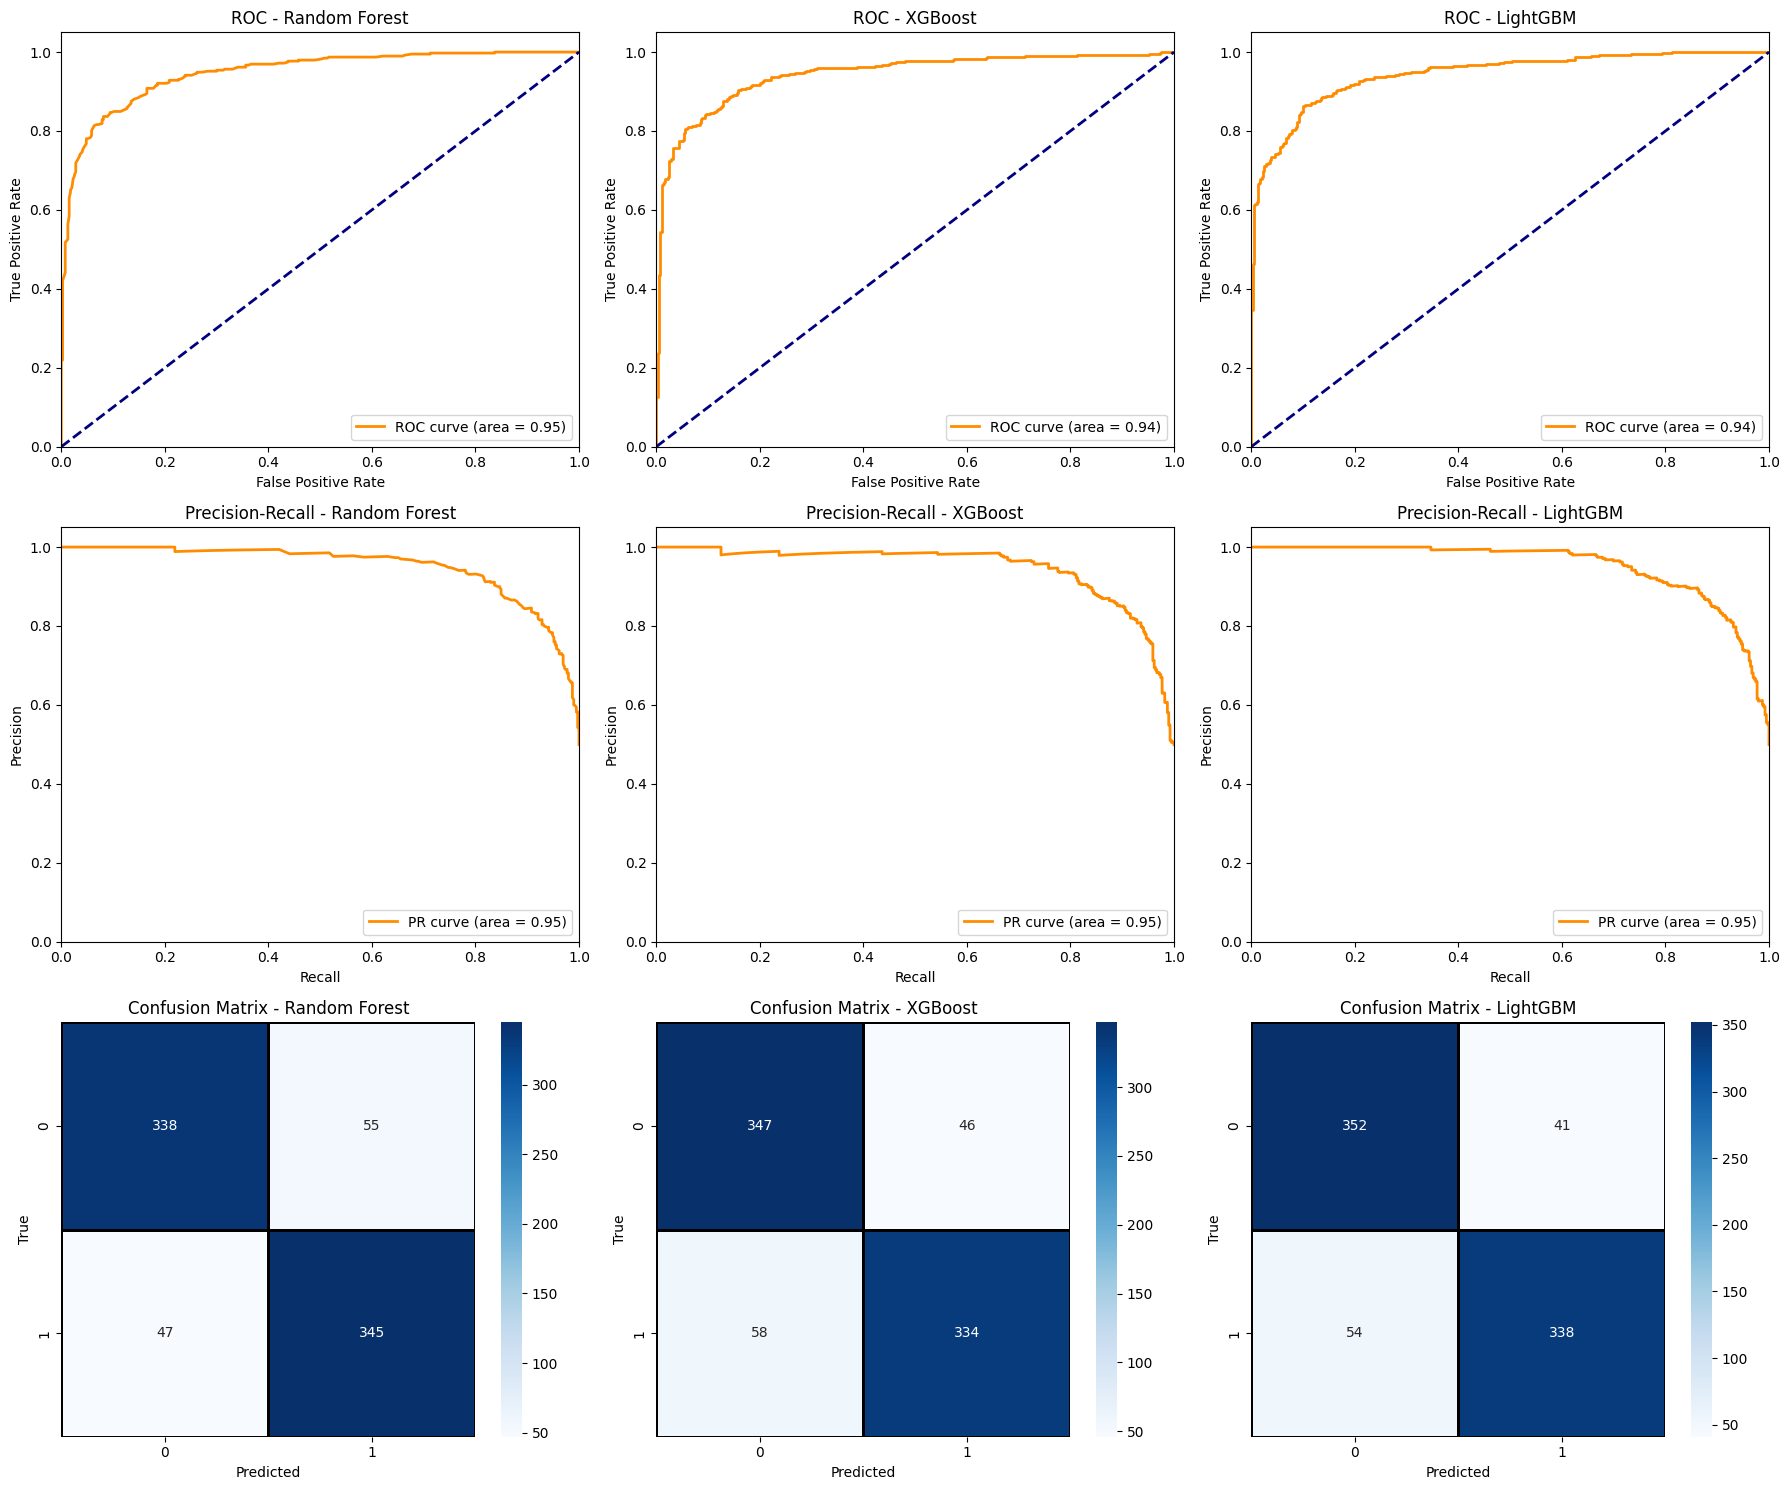

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_all_metrics(models, X_test, y_test, model_names):
    fig, axes = plt.subplots(nrows=3, ncols=len(models), figsize=(18, 15))
    
    for i, model in enumerate(models):
        # ROC Curve
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        axes[0, i].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        axes[0, i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0, i].set_xlim([0.0, 1.0])
        axes[0, i].set_ylim([0.0, 1.05])
        axes[0, i].set_xlabel('False Positive Rate')
        axes[0, i].set_ylabel('True Positive Rate')
        axes[0, i].set_title(f'ROC - {model_names[i]}')
        axes[0, i].legend(loc="lower right")
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        axes[1, i].plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
        axes[1, i].set_xlim([0.0, 1.0])
        axes[1, i].set_ylim([0.0, 1.05])
        axes[1, i].set_xlabel('Recall')
        axes[1, i].set_ylabel('Precision')
        axes[1, i].set_title(f'Precision-Recall - {model_names[i]}')
        axes[1, i].legend(loc="lower right")
        
        # Confusion Matrix
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black', ax=axes[2, i])
        axes[2, i].set_xlabel('Predicted')
        axes[2, i].set_ylabel('True')
        axes[2, i].set_title(f'Confusion Matrix - {model_names[i]}')

    plt.tight_layout()
    plt.savefig(os.path.join(visual_dir, f'metrics_{trial_number_ml}.png'))
    plt.show()

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
plot_all_metrics(models, X_test, y_test, model_names)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_roc_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
metrics_list = []

def evaluate_model_performance(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
    }
    return metrics


# Plotting functions modified to save figures
def plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml):
    for model, model_name in zip(models, model_names):
        # ROC Curve
        plot_roc_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'roc_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Precision-Recall Curve
        plot_precision_recall_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'precision_recall_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Confusion Matrix
        plot_confusion_matrix(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'confusion_matrix_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()



In [12]:
# Evaluate and save metrics for each model
for model, name in zip(models, model_names):
    metrics = evaluate_model_performance(model, X_test, y_test, name)
    metrics_list.append(metrics)
    print(f"Metrics for {name}: {metrics}")

# Convert metrics to DataFrame sort bu 'Accuracy' and save
metrics_df = pd.DataFrame(metrics_list)
sorted_metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)
sorted_metrics_df.to_csv(os.path.join(results_dir, f'sorted_metrics_df_{trial_number_ml}.csv'), index=False)

Metrics for Random Forest: {'Model': 'Random Forest', 'Accuracy': 0.870063694267516, 'Precision': 0.8625, 'Recall': 0.8801020408163265, 'F1 Score': 0.8712121212121212, 'ROC AUC': 0.9465226930466843}
Metrics for XGBoost: {'Model': 'XGBoost', 'Accuracy': 0.867515923566879, 'Precision': 0.8789473684210526, 'Recall': 0.8520408163265306, 'F1 Score': 0.8652849740932642, 'ROC AUC': 0.9423456405462947}
Metrics for LightGBM: {'Model': 'LightGBM', 'Accuracy': 0.8789808917197452, 'Precision': 0.8918205804749341, 'Recall': 0.8622448979591837, 'F1 Score': 0.8767833981841764, 'ROC AUC': 0.9436243963234149}


In [13]:
metrics

{'Model': 'LightGBM',
 'Accuracy': 0.8789808917197452,
 'Precision': 0.8918205804749341,
 'Recall': 0.8622448979591837,
 'F1 Score': 0.8767833981841764,
 'ROC AUC': 0.9436243963234149}

In [14]:
# Assuming you have a list called metrics_list which contains the metrics dictionaries for each model
# And assuming each dictionary has a 'Model' key with the model's name and an 'Accuracy' key with its accuracy

# Extract accuracy scores and model names from metrics_list
accuracy_scores = [metrics['Accuracy'] for metrics in metrics_list]
model_names = [metrics['Model'] for metrics in metrics_list]

# Find the index of the highest accuracy
best_model_index = accuracy_scores.index(max(accuracy_scores))

# Retrieve the best model and its name using the index
best_model = models[best_model_index]
best_model_name = model_names[best_model_index]

# Print the best model name and its accuracy
print(f"Best Model: {best_model_name} with Accuracy: {accuracy_scores[best_model_index]:.4f}")


Best Model: LightGBM with Accuracy: 0.8790


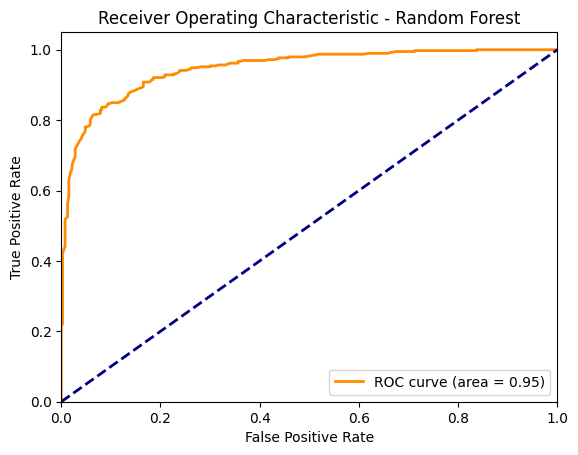

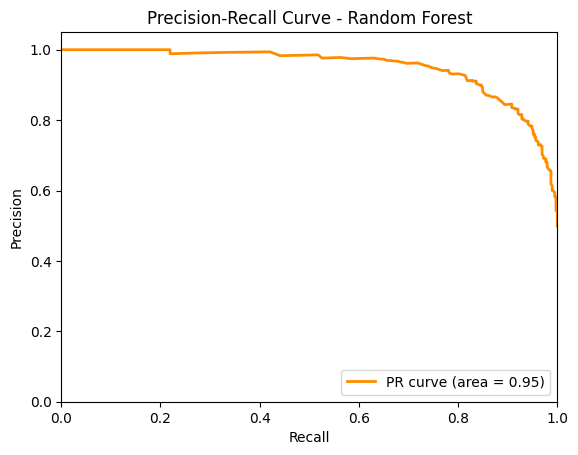

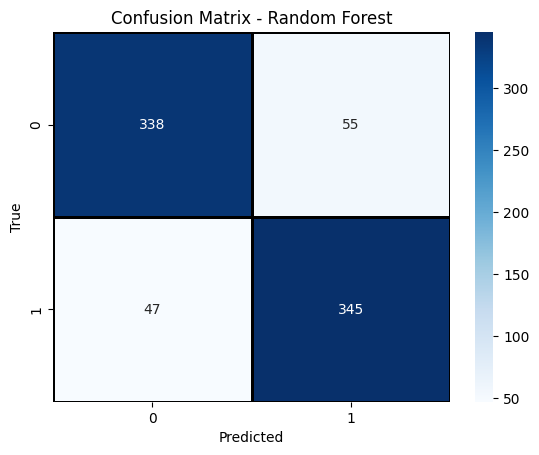

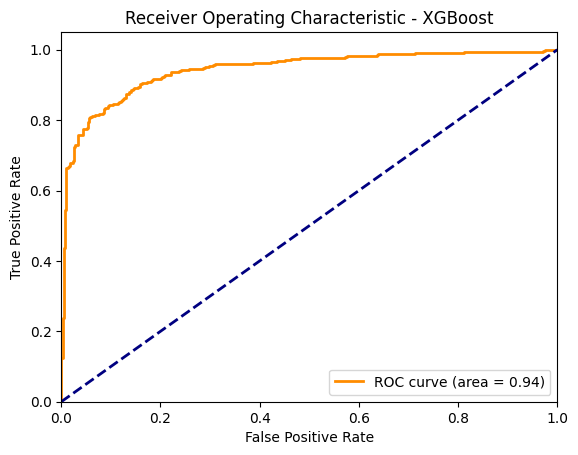

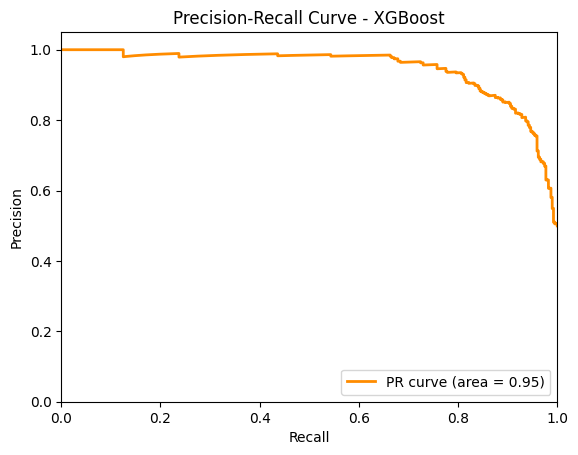

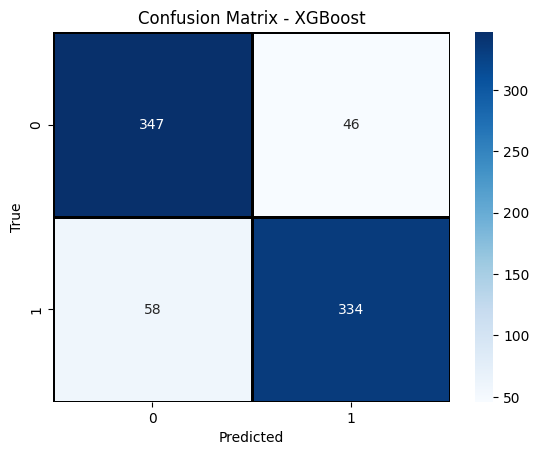

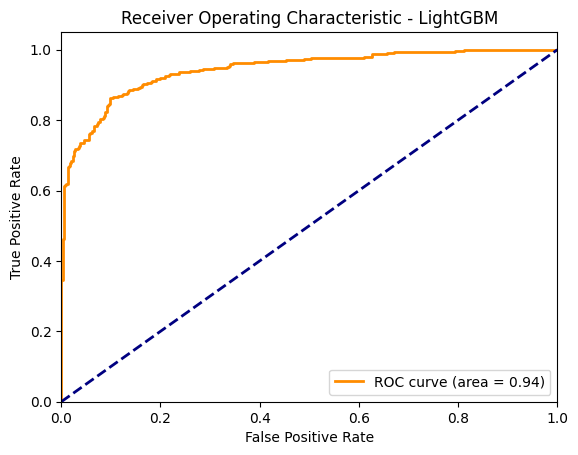

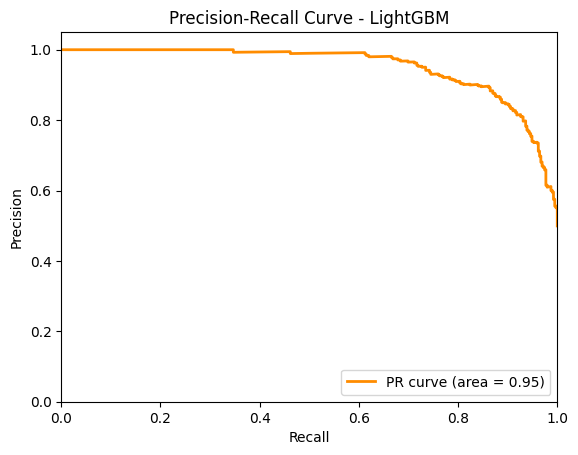

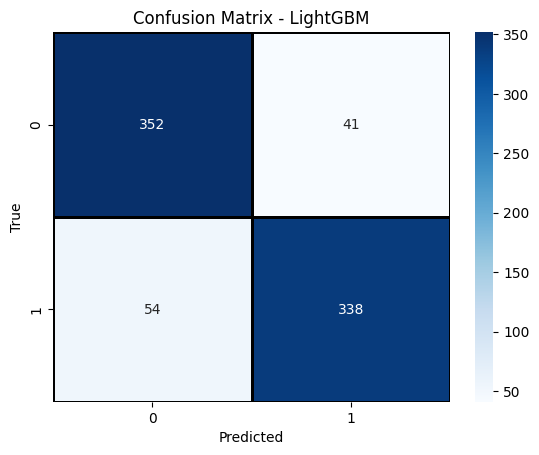

In [15]:
plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml)


In [16]:
def extract_feature_importances(model, feature_names):
    """
    Extract and sort the feature importances from the model.
    """
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    return feature_names[sorted_idx], feature_importances[sorted_idx]

def plot_feature_importances(feature_names, feature_importances, title='Feature Importances', n_features=20):
    """
    Visualize the top N feature importances for interpretability.
    """
    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature_importances[:n_features], y=feature_names[:n_features], orient='h')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature (Bit Index)')
    plt.savefig(os.path.join(features_dir, f'feature_importances_{trial_number_ml}.png'), dpi=300)
    plt.show()

def identify_important_features(feature_names, feature_importances, threshold=0.002):
    """
    Identify features with importance greater than a specified threshold.
    """
    return feature_names[feature_importances > threshold], feature_importances[feature_importances > threshold]

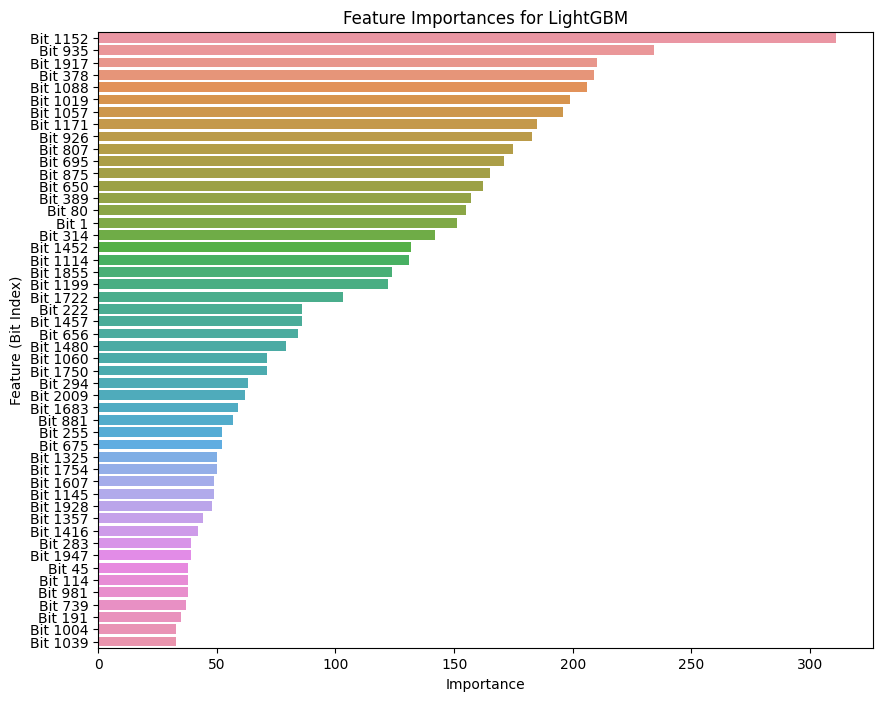

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

feature_names = np.array(["Bit " + str(i) for i in range(X_train.shape[1])])  # Adjust based on your X_train


def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Save to CSV
    features_df = pd.DataFrame({
        'Feature': sorted_names,
        'Importance': sorted_importances
    })
    csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}.csv')
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=50)
    plt.close()

save_feature_importances(best_model, feature_names, best_model_name, trial_number_ml)


In [18]:
import time

def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Define file paths
    timestamp = time.strftime("%Y%m%d-%H%M%S")  # Current timestamp
    csv_filename = f'feature_importances_{model_name}_{trial_number}.csv'
    plot_filename = f'feature_importances_plot_{model_name}_{trial_number}.png'
    
    # Check if files exist and append timestamp to avoid overwriting
    csv_path = os.path.join(features_dir, csv_filename)
    if os.path.exists(csv_path):
        csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}_{timestamp}.csv')
    
    plot_path = os.path.join(features_dir, plot_filename)
    if os.path.exists(plot_path):
        plot_path = os.path.join(features_dir, f'feature_importances_plot_{model_name}_{trial_number}_{timestamp}.png', dpi=300)

    # Save to CSV
    features_df = pd.DataFrame({'Feature': sorted_names, 'Importance': sorted_importances})
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=20)
    plt.savefig(plot_path)
    plt.close()
